In [1]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
from rasterio.features import rasterize
import rioxarray
from scipy.ndimage import binary_dilation
from shapely.geometry import box
from typing import Tuple
import xarray

# Introduction
#### In this notebook, I use Lidar images and combine them with the levee data (from w1 and w2 directories) to create masks (targets) for model training.

To read more about how the data looks like, see previous notebook 1.0.

In [2]:
# Load the images
data_dir = "../data/raw/w2-Lidar"
tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
images = [rioxarray.open_rasterio(os.path.join(data_dir, file)) for file in tif_files[:]]

# Load the levees data
levees_file = "../data/raw/w1-Kickoff/us_levees_n38w122.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_3717 = levees_data.to_crs("EPSG:3717")

# General Strategy

The task is straightforward, for given Lidar image, we would want to create a mask which will be used to train a model how it is supposed to mark the levees. We need to take the following steps:

1. For given Lidar image, check which (if any) levees from the database intersect with it
2. Replace all the background with a single value (for example here it is 1)
3. Plot the corresponding (at least partially) intersecting levee lines on top of background in scale (here levees are plotted as 0)
4. The levee lines are single pixel thick, we can make them a bit thicker so that they can actually roughly cover the levees, 

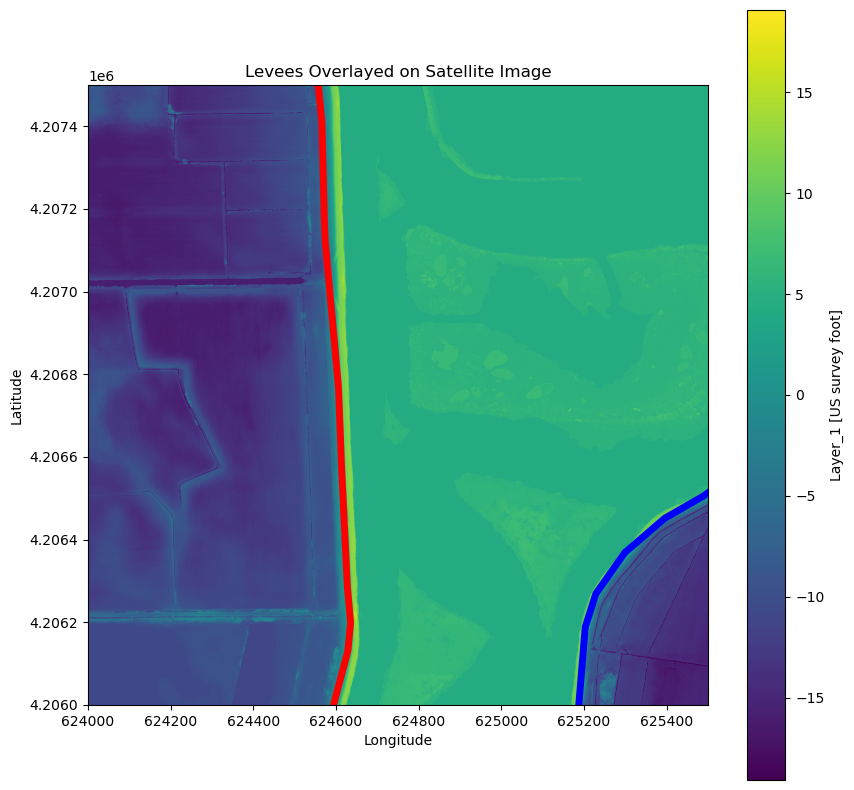

In [3]:
# This is an example of levees intersecting with a Lidar image

# I checked before, by looking at max and min coordinates of each image and levee,
# that potentially 3 levees may intersect with this image
# Here I show results of plotting that.
# As can be seen, actually only two levees intersect with this image.

fig, ax = plt.subplots(figsize=(10, 10))
img = images[8]
img.plot(ax=ax, cmap="viridis")

# Overlay the levee data
levees_data_3717.iloc[9:10].plot(ax=ax, color="red", linewidth=5) 
levees_data_3717.iloc[32:33].plot(ax=ax, color="blue", linewidth=5)
levees_data_3717.iloc[59:60].plot(ax=ax, color="black", linewidth=5)

plt.title("Levees Overlayed on Satellite Image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [4]:
# As mentioned in the previous notebook, Lidar images have bounds attribute
# We can use that to define a box from shapely.geometry library
img_box = box(*img.rio.bounds())

In [5]:
# Now that we have a box, we can use the fact that levees are 
# LineStrings which is from shapely.geometry as well, and check 
# which levees intersect with given box:
levees_data_3717.intersects(img_box)[:14]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12    False
13    False
dtype: bool

In [6]:
# Of all the levees, find the ones that intersect with the box
levees_in_extent = levees_data_3717[levees_data_3717.intersects(img_box)]
levees_in_extent

states floodplainManagement districtNames   lon  leveeLengthInMiles  \
9   California        FEMA Region 9    Sacramento  W122           10.866458   
32  California        FEMA Region 9    Sacramento  W122           14.313913   

    lat                                        location  \
9   N38  Bethel Island, Contra Costa County, California   
32  N38       Knightsen, San Joaquin County, California   

    leveedAreaSquareMiles     communitiesBreakdown  yearConstructed  \
9                6.441300  Contra Costa County, CA              NaN   
32               8.600377   San Joaquin County, CA              NaN   

                            name  \
9   Contra Costa County Levee 17   
32  San Joaquin County Levee 146   

                                             geometry  
9   LINESTRING Z (624606.155 4206765.973 0.0001, 6...  
32  LINESTRING Z (629478.095 4206842.396 0.0001, 6...

In [7]:
# Now lets see a different image (images[4]). 
# As can be seen none of the levees in the database intersect with it
levees_data_3717[levees_data_3717.intersects(box(*images[4].rio.bounds()))]


Empty GeoDataFrame
Columns: [states, floodplainManagement, districtNames, lon, leveeLengthInMiles, lat, location, leveedAreaSquareMiles, communitiesBreakdown, yearConstructed, name, geometry]
Index: []

In [8]:
img.shape[-2:]

(3000, 3000)

In [9]:
# To create a mask, we can use the rasterio.features.rasterize function
# Which returns an image array with input geometries burned in
# In our cases the geometries will be all the intersecting levees.

shape = img.shape[-2:] #(3000, 3000)
transform = img.rio.transform() # Affine transformation matrix (see notebook 1.0)

levee_raster = rasterize(
        [(geom, 1) for geom in levees_in_extent.geometry],  # Geometry and value
        out_shape=shape,
        transform=transform,
        fill=0,  # Default value for areas without levees
        dtype="uint8",
    )

levee_raster

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
np.max(levee_raster)

1

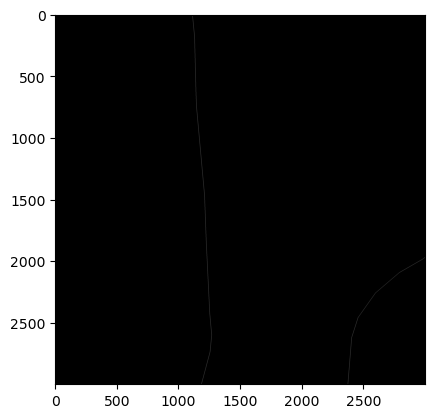

In [11]:
# We are practically ready, now all thats left is to make the levee lines 
# a bit thicker as currently they are just 1 pixel width:
plt.imshow(levee_raster, cmap='grey')

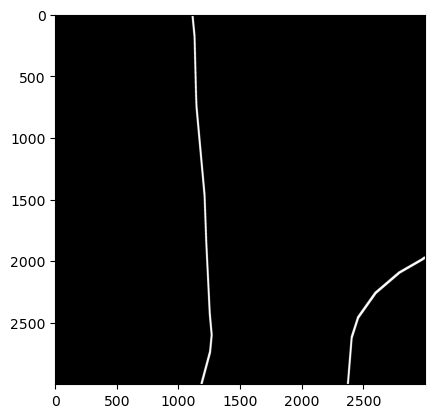

In [12]:
# Thicken the white lines using binary dilation
structure = np.ones((15, 15), dtype=bool)  # Defines the dilation kernel
thickened_raster = binary_dilation(levee_raster, structure=structure).astype(np.uint8)

plt.imshow(thickened_raster, cmap='grey')

In [13]:
isinstance(img, xarray.DataArray)

True

In [14]:
# Based on this, a function is defined, which given an input of a single Lidar image which is
# a xarray.DataArray, and a geopandas dataframe of levees, returns the image and the mask
# invert=True will result in target pixels marked as 0, and non-target pixels marked as 1
# Note: the current version inside levee_hunter.get_mask is slightly different, but the general 
# idea is the same.

def get_mask(
    tif_image: xarray.DataArray, 
    levees: gpd.GeoDataFrame, 
    invert: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a tif image and a geopandas dataframe of levees, return the image and the mask.

    Parameters:
    - tif_image: A rioxarray DataArray containing the raster data.
    - levees: A GeoDataFrame containing levee geometries.
    - invert: If True, inverts the mask.

    Returns:
    - A tuple containing:
      1. The original raster image as a NumPy array.
      2. The binary mask as a NumPy array.
    """
    transform = tif_image.rio.transform()  # Affine transformation
    shape = tif_image.shape[-2:]  # Shape of the raster (rows, cols)

    # Filter levees that intersect the tif extent
    extent_geom = tif_image.rio.bounds()  # Bounds of the tif image
    extent_box = box(*extent_geom)  # Define bounding box as shapely geometry
    levees_in_extent = levees[levees.intersects(extent_box)]

    # Rasterize levees onto the same grid as the tif
    levee_raster = rasterize(
        [(geom, 1) for geom in levees_in_extent.geometry],  # Geometry and value
        out_shape=shape,
        transform=transform,
        fill=0,  # Default value for areas without levees
        dtype="uint8",
    )

    # Thicken the white lines using binary dilation
    structure = np.ones((15, 15), dtype=bool)  # Defines the dilation kernel
    thickened_raster = binary_dilation(levee_raster, structure=structure).astype(np.uint8)

    if invert:
        thickened_raster = 1 - thickened_raster

    return tif_image.values, thickened_raster

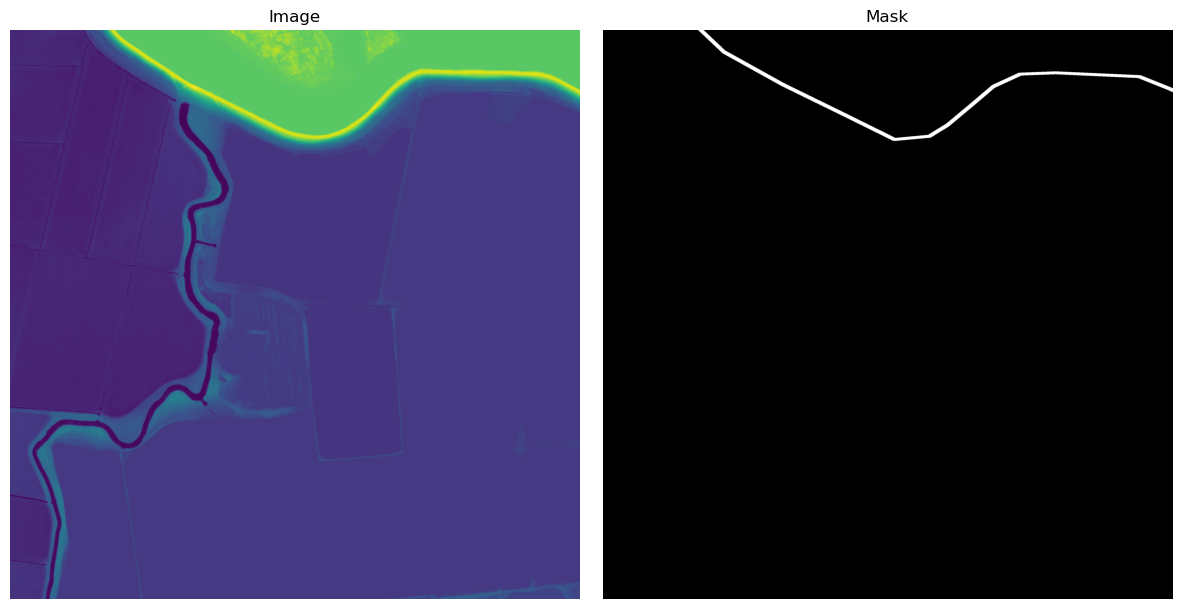

In [15]:
img1, img1_mask = get_mask(images[0], levees_data_3717, invert=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].imshow(img1.reshape(3000, 3000), cmap="viridis")
axes[0].set_title("Image")
axes[0].axis("off")  

axes[1].imshow(img1_mask, cmap=ListedColormap(["white", "black"]))
axes[1].set_title("Mask")
axes[1].axis("off")  # Hide axes for better visualization

plt.tight_layout()
plt.show()

In [16]:
# Now for all images:
lidar_images = []
targets = []
for image in images:
    lidar_data, target = get_mask(image, levees_data_3717, invert=True)
    lidar_data = lidar_data.reshape(lidar_data.shape[1], lidar_data.shape[2])
    lidar_images.append(lidar_data)
    targets.append(target)

lidar_images = np.array(lidar_images)
targets = np.array(targets)

lidar_images.shape

(22, 3000, 3000)

0


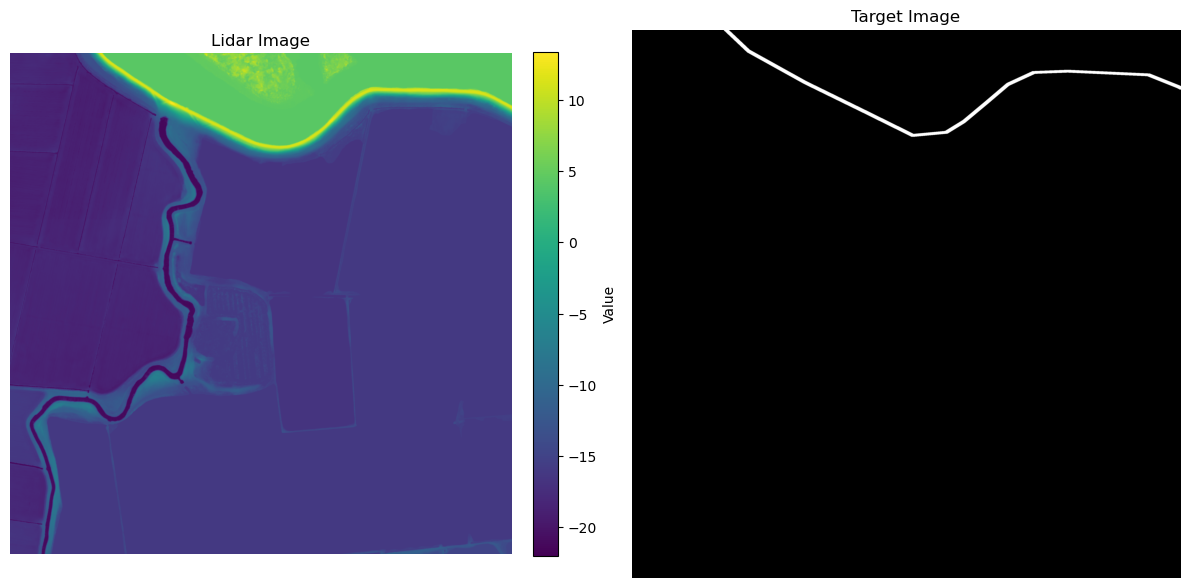

1


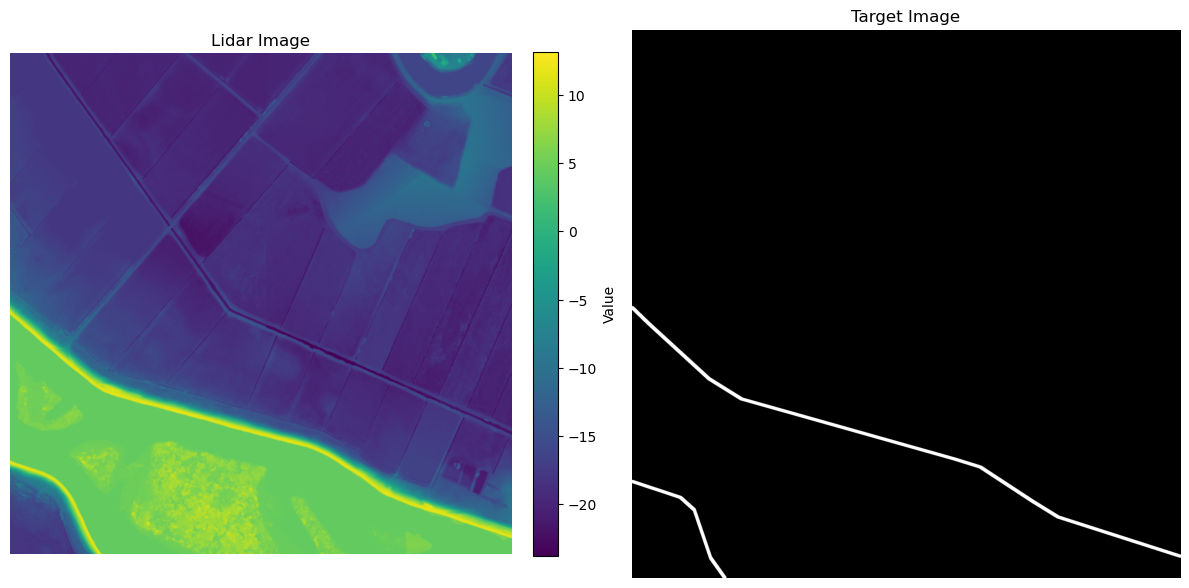

2


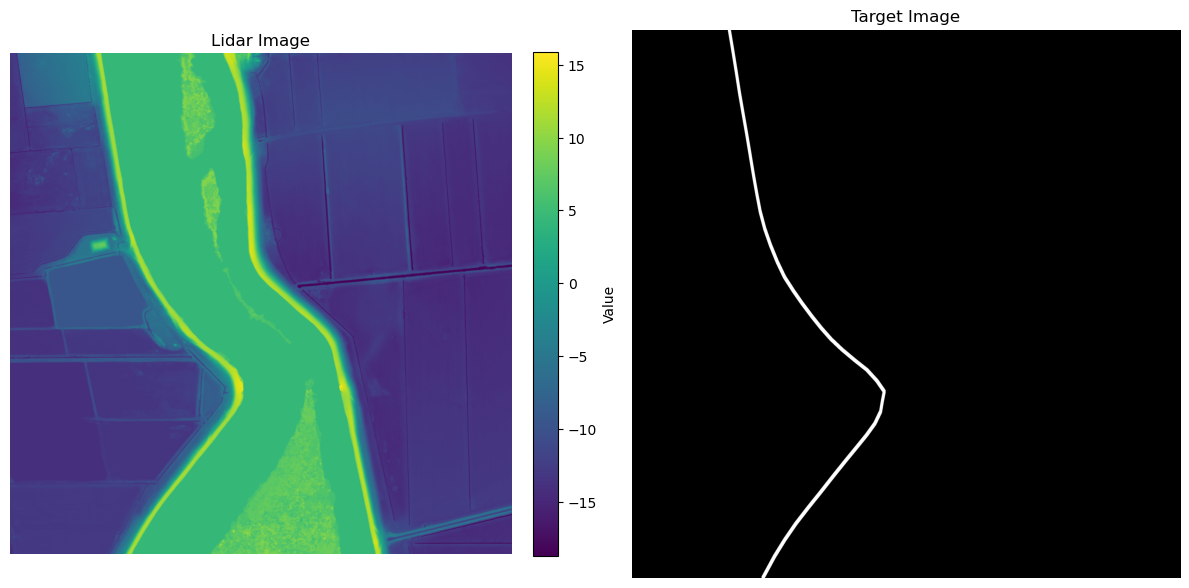

3


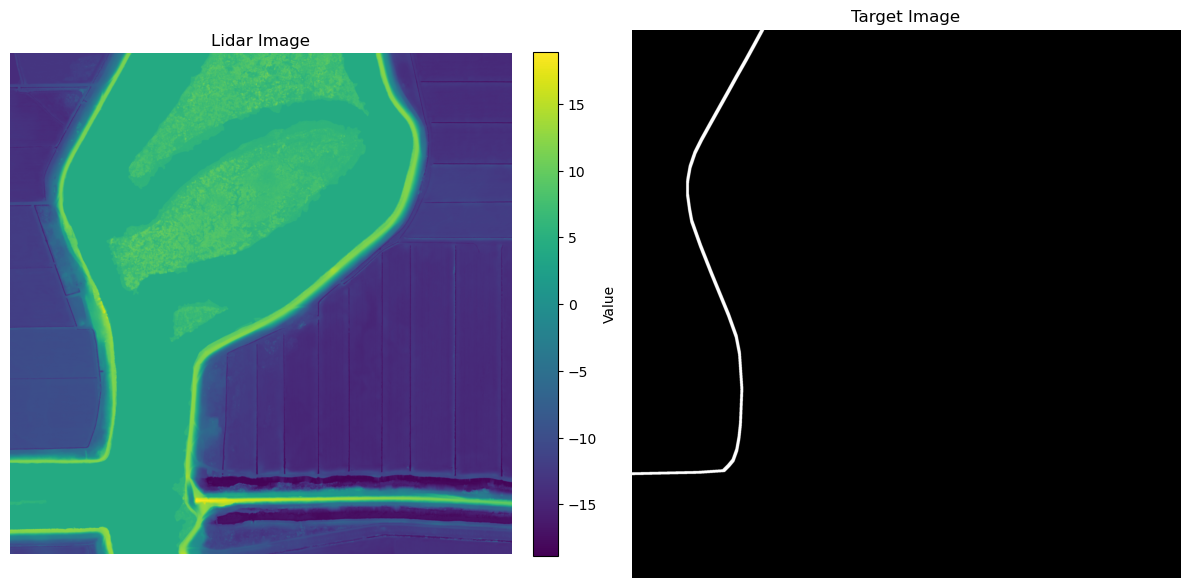

4


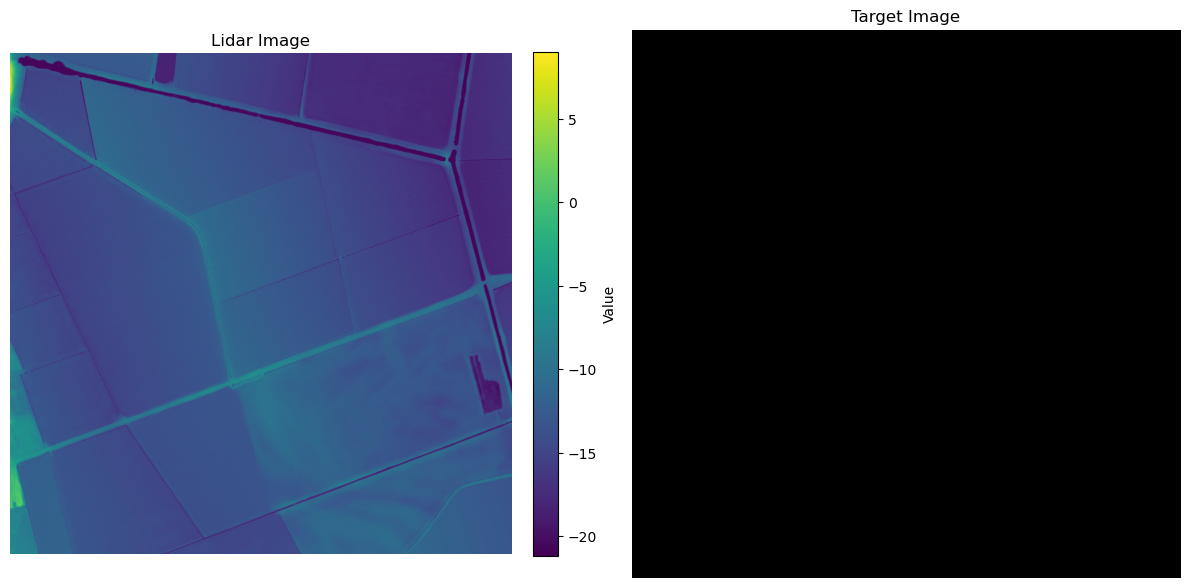

5


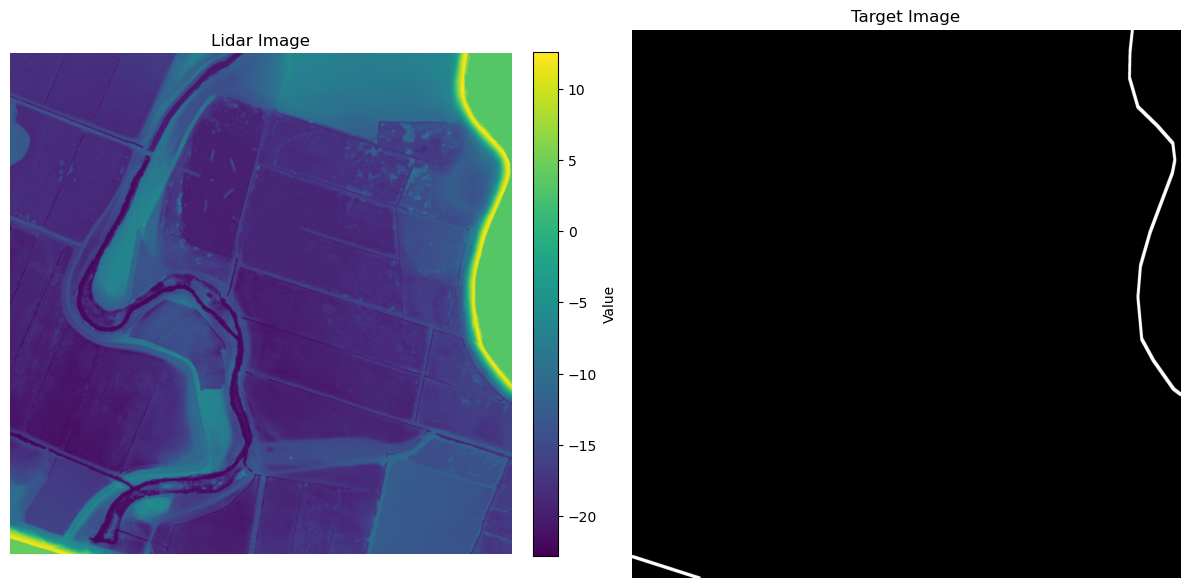

6


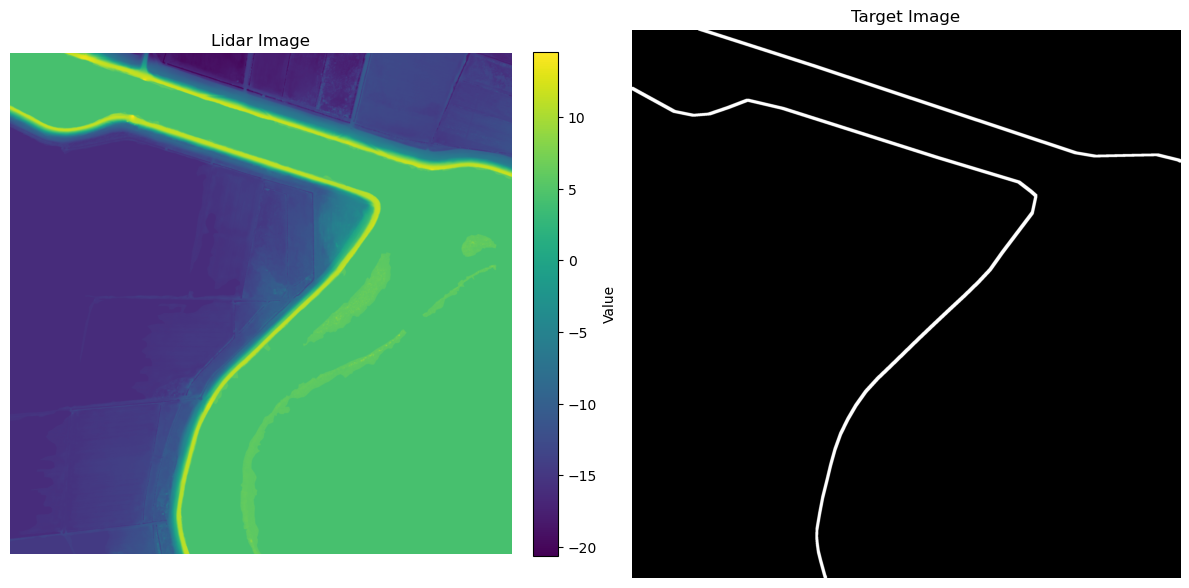

7


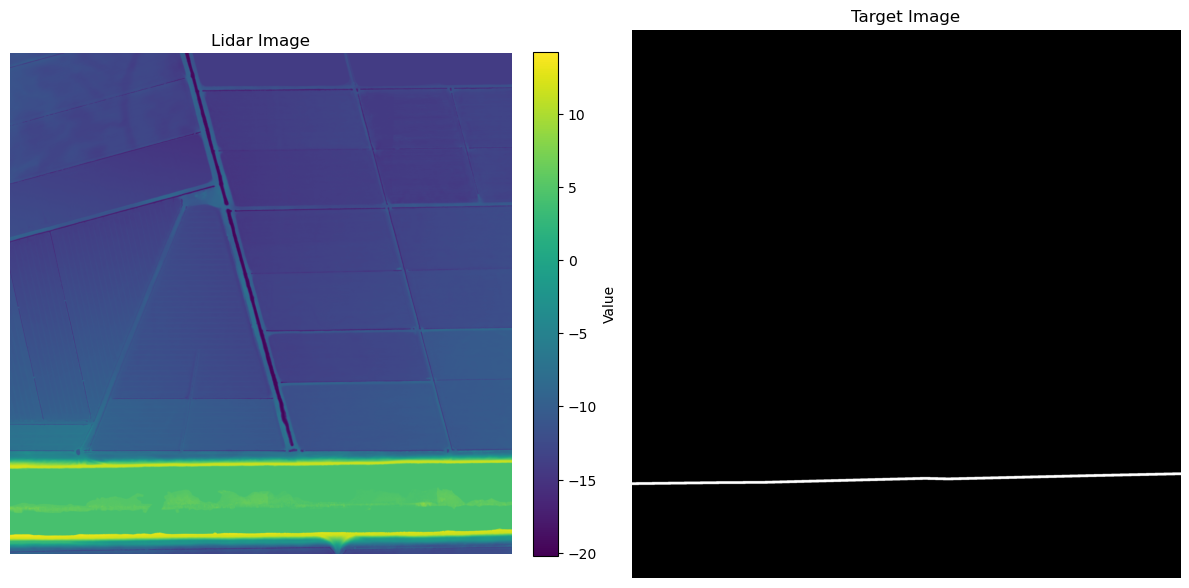

8


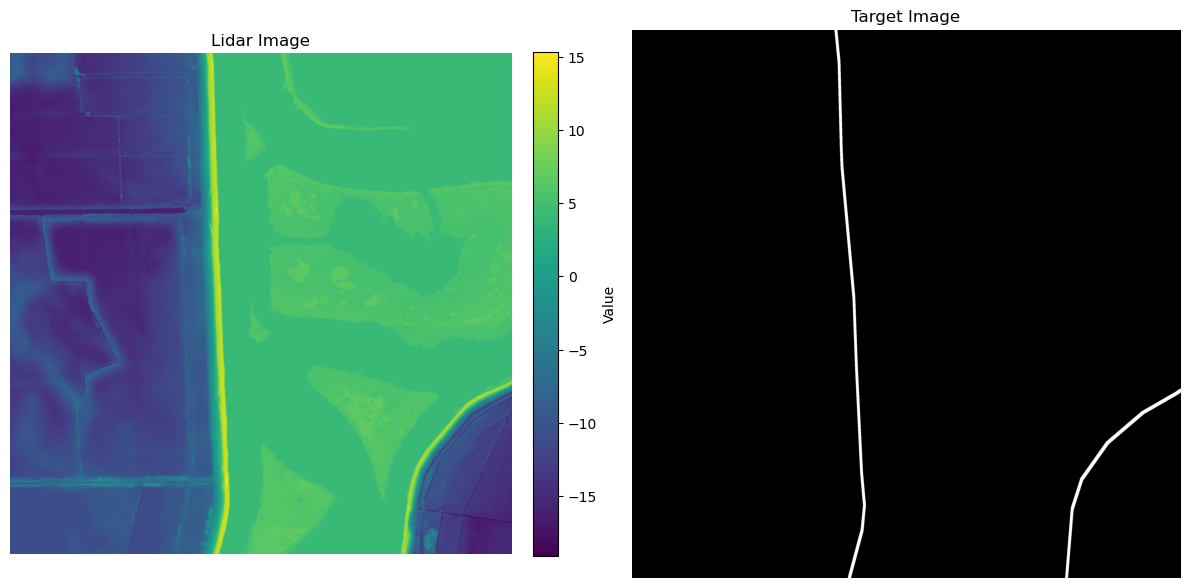

9


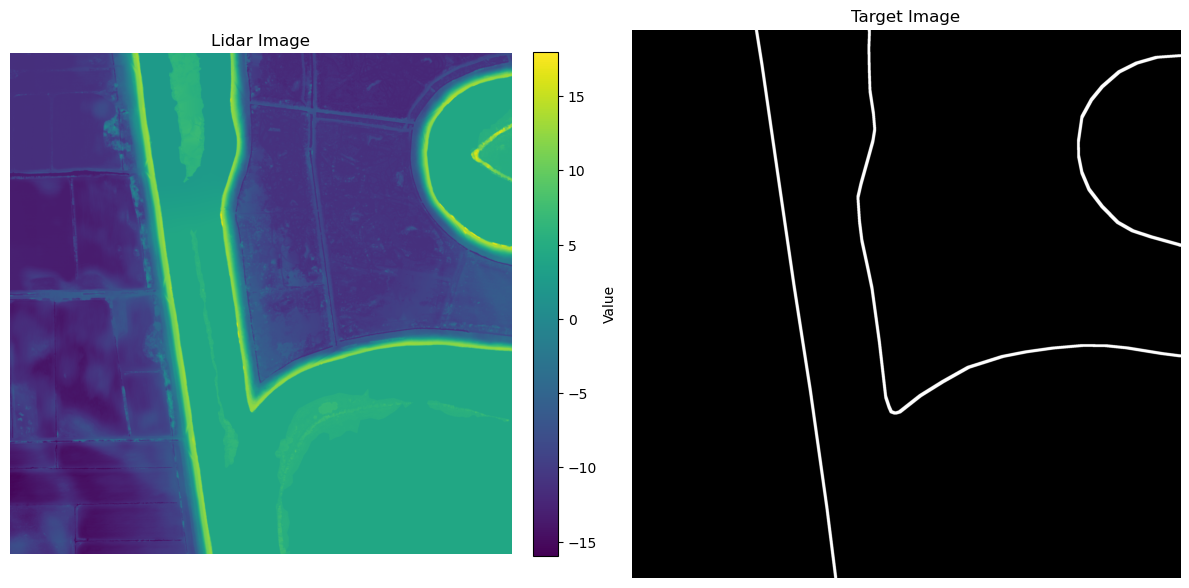

10


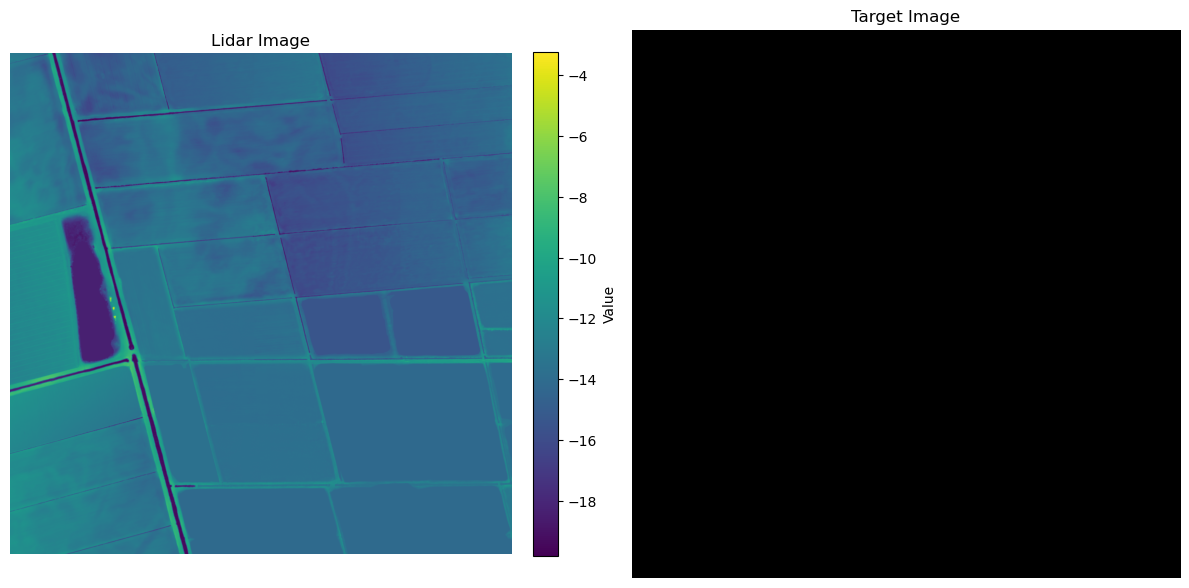

11


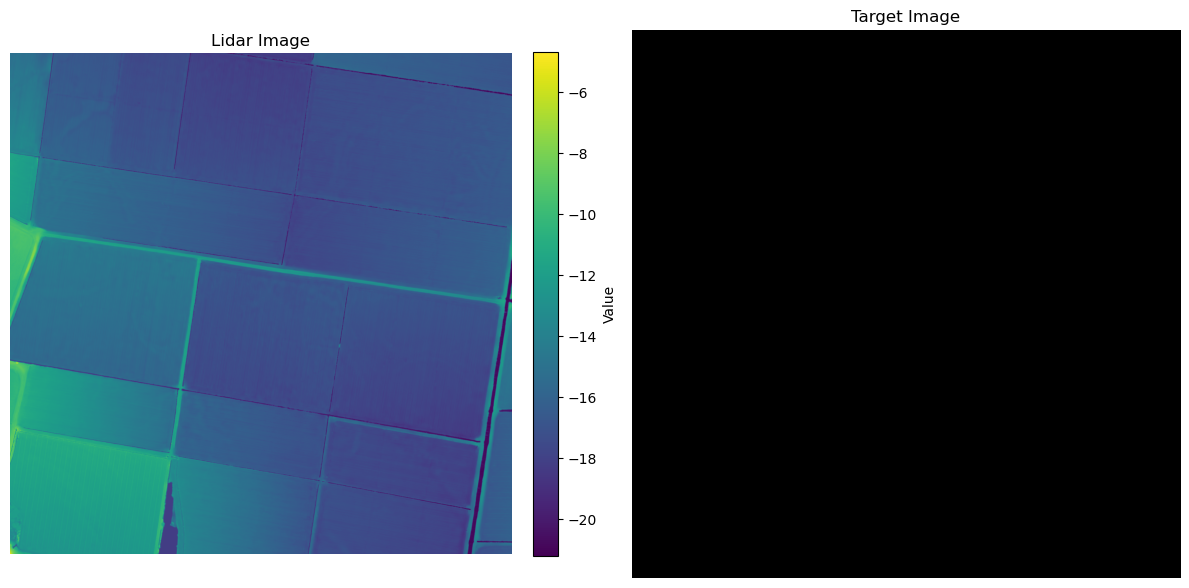

12


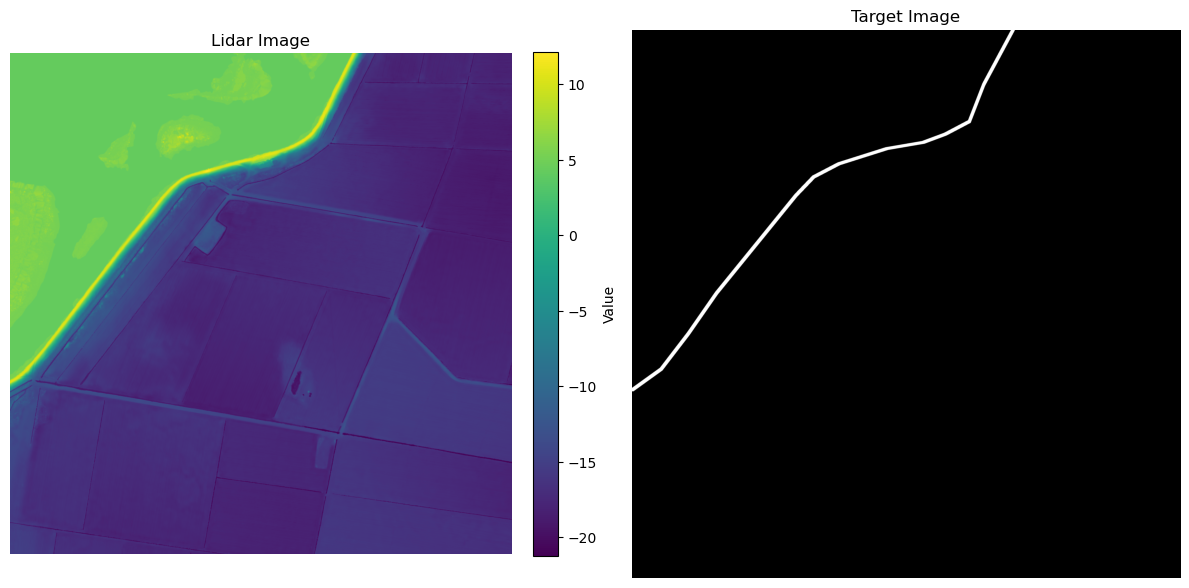

13


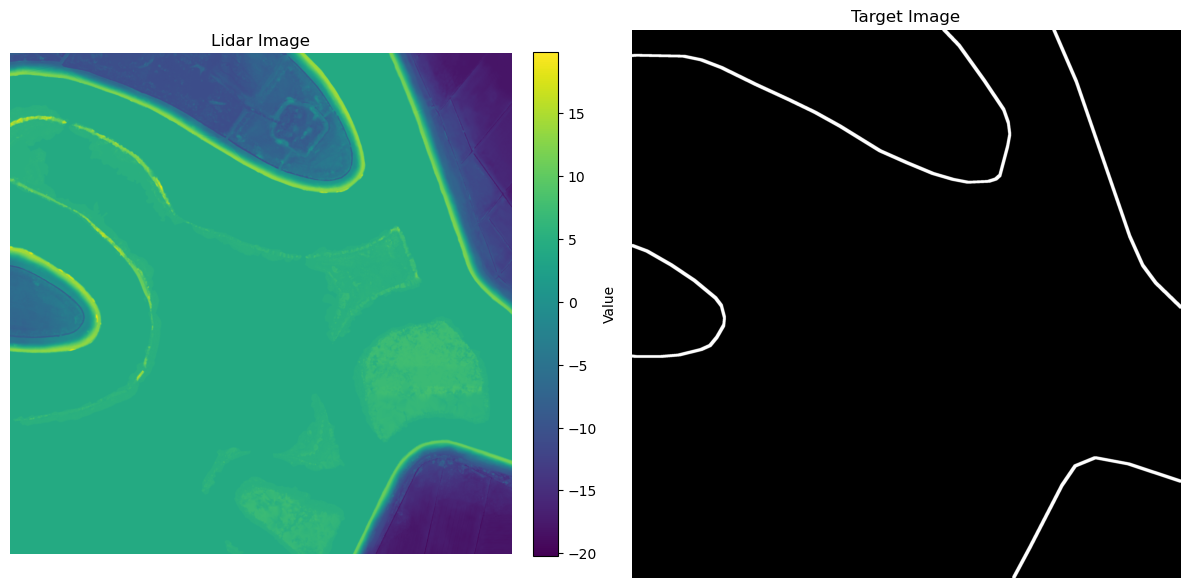

14


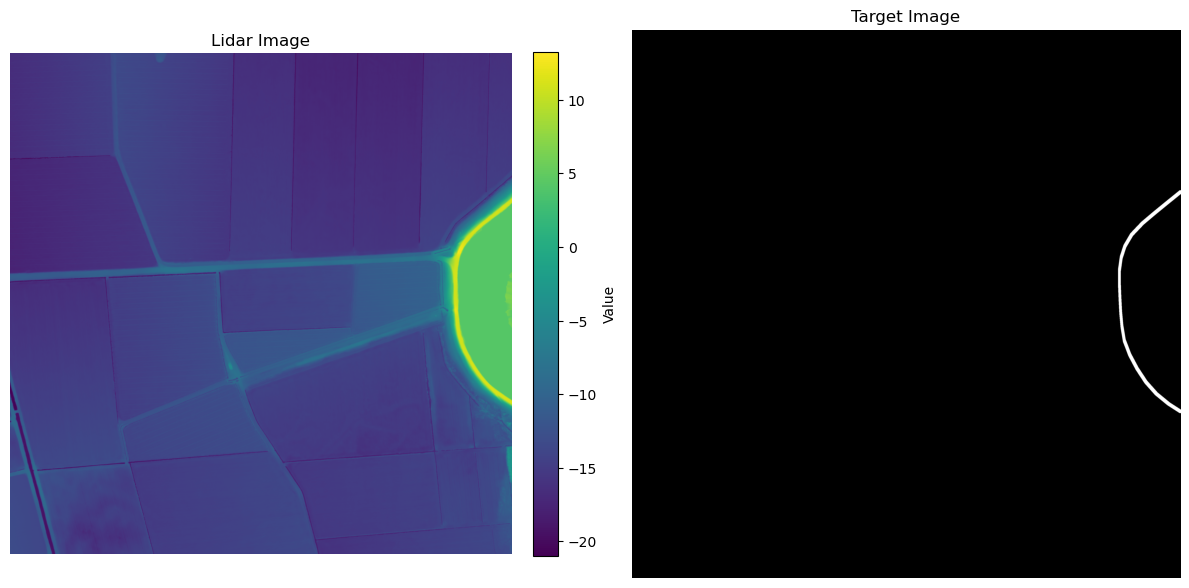

15


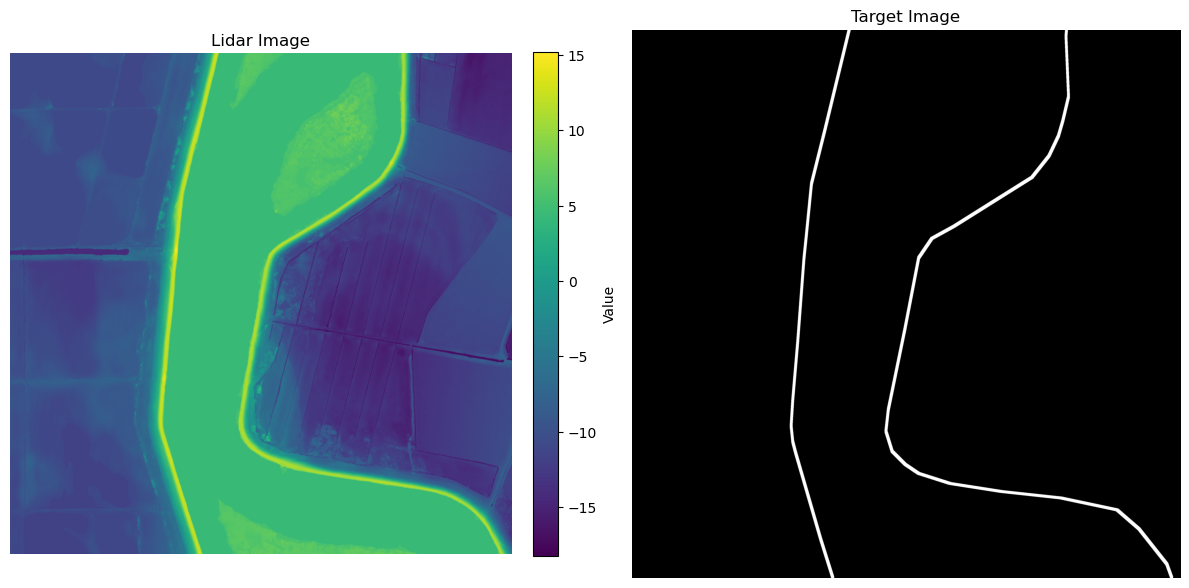

16


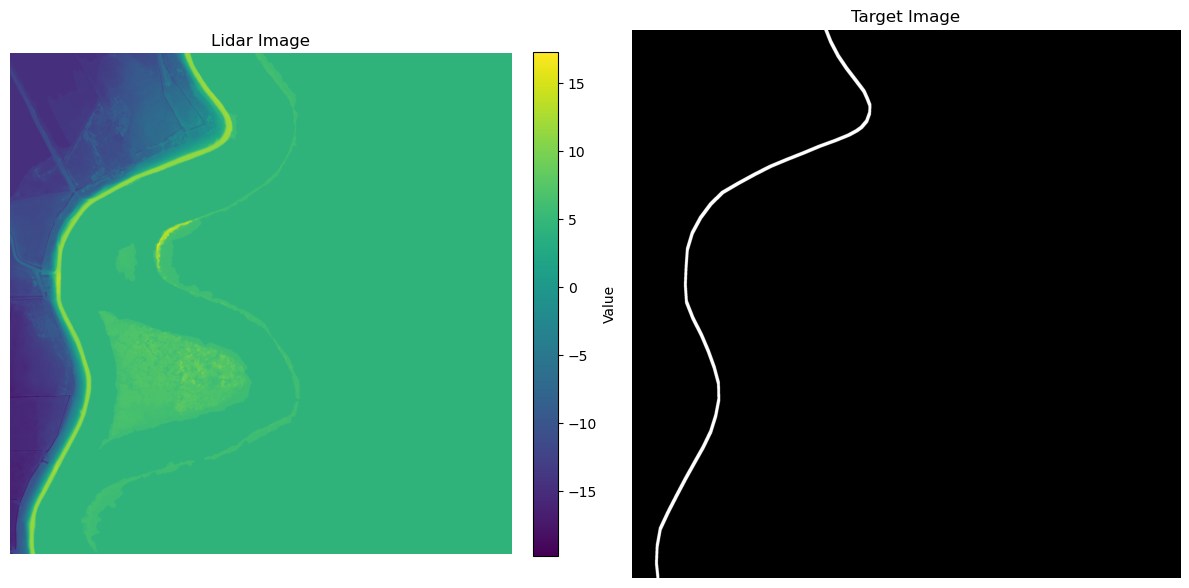

17


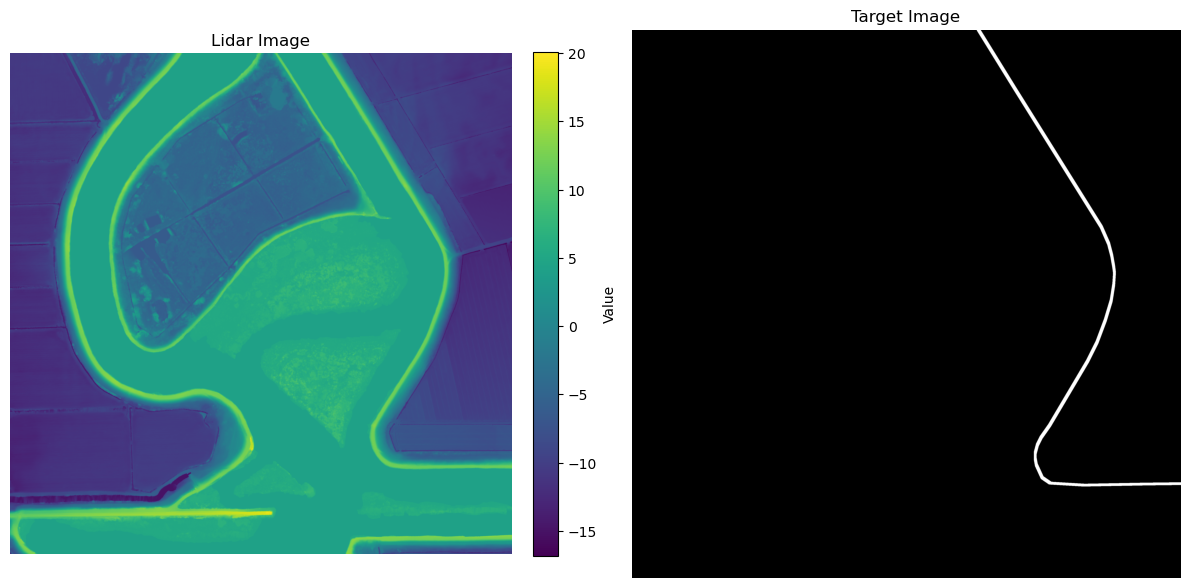

18


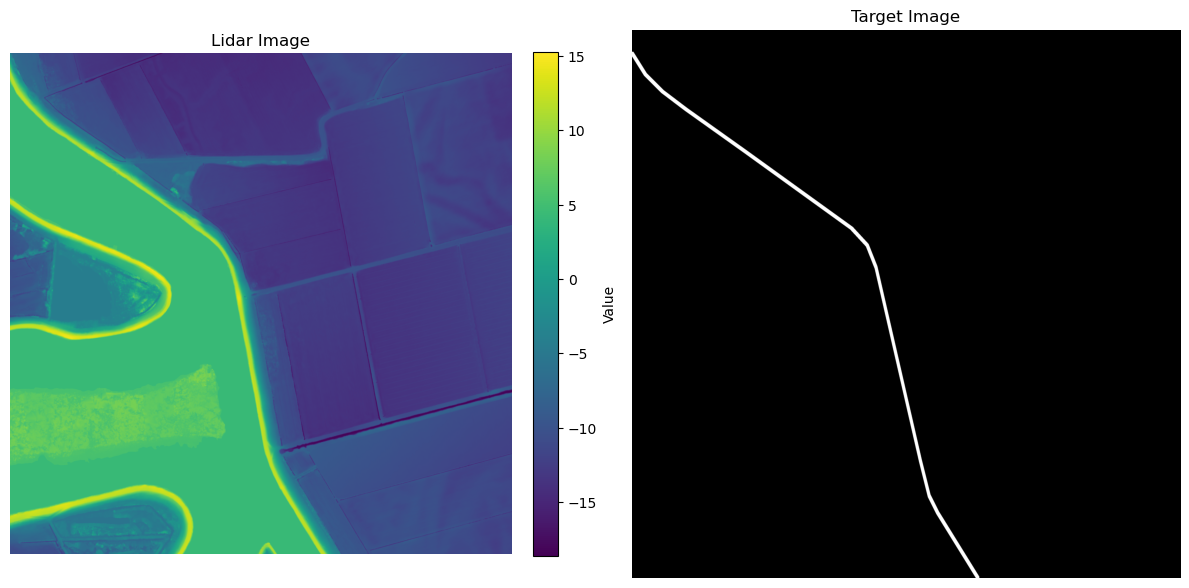

19


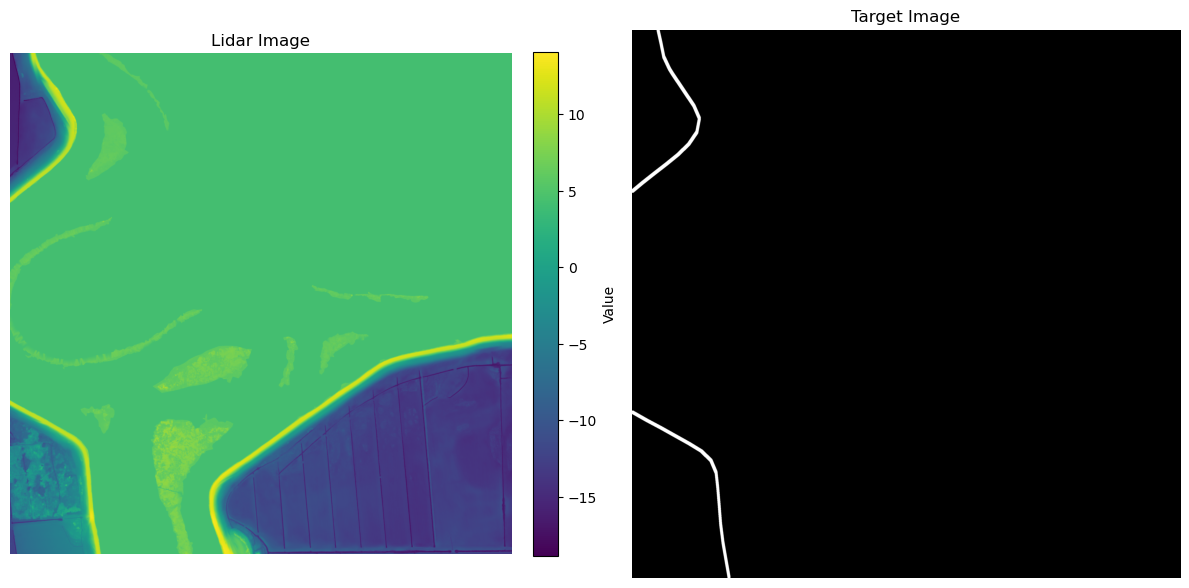

20


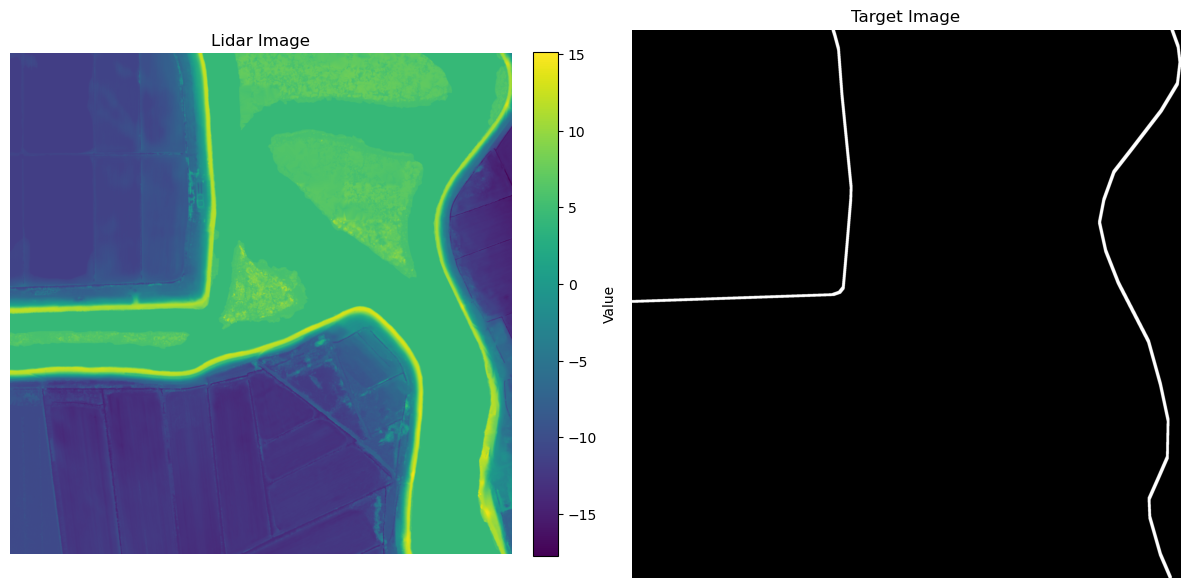

21


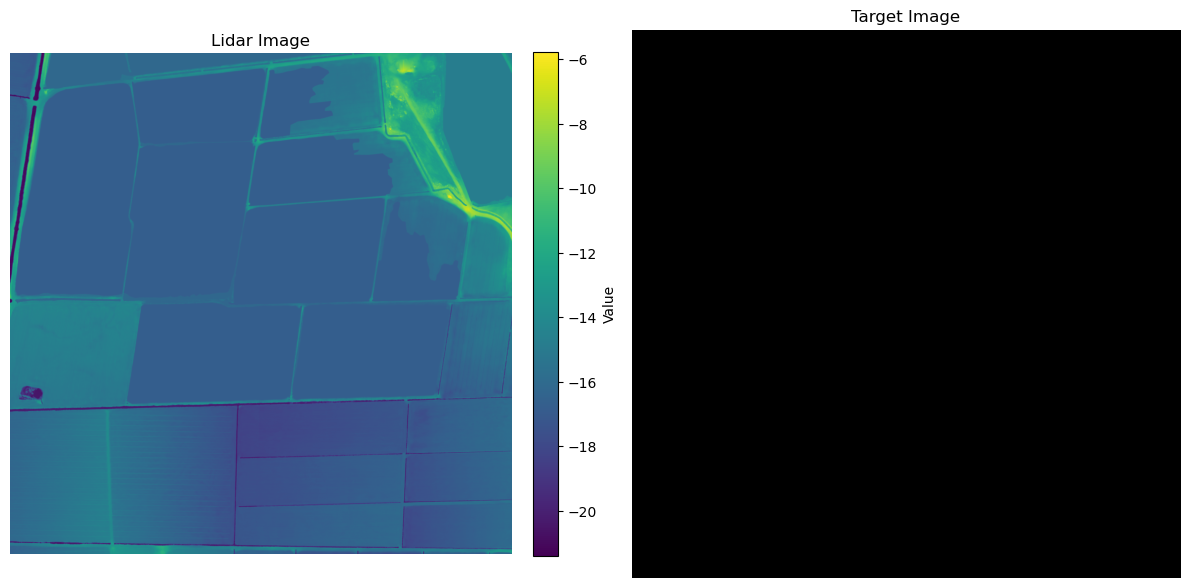

In [17]:
for ix in range(len(lidar_images)):   
    print(ix)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plot the first image
    im = axes[0].imshow(lidar_images[ix], cmap="viridis")
    axes[0].set_title("Lidar Image")
    axes[0].axis("off")

    cbar = fig.colorbar(im, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Value")  # Optional: Label for the colorbar

    # Plot the second image
    axes[1].imshow(targets[ix], cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)  # Explicitly map 0->white, 1->black
    axes[1].set_title("Target Image")
    axes[1].axis("off")  # Hide axes for cleaner visualization

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()